In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [4]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=range(2006, 2021),
    time_group='12h',
    price_calculation='close',
)

In [5]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [6]:
price_data = add_features(price_data.copy())

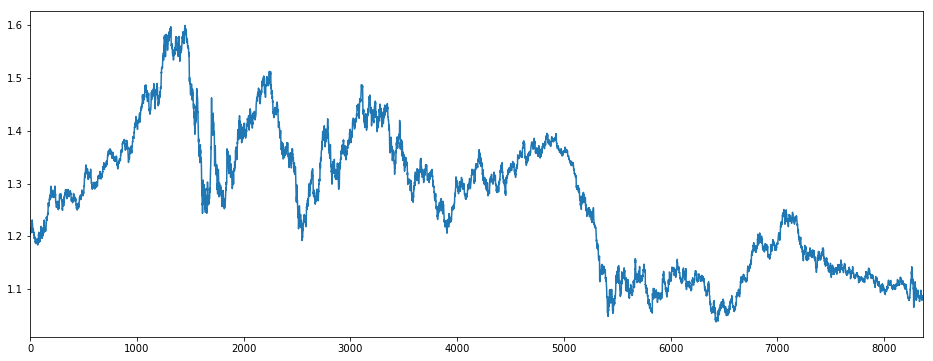

In [7]:
price_data['price'].plot(figsize=(16,6))

In [8]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 5577, test size 2788


In [9]:
episode=1000
batch_size=10

In [11]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-12 12:00:00,1.20430,1.21392,1.20072,1.21368,1.20430,0.419520,0.007157,0.451709
1,1,2006-01-13 00:00:00,1.20542,1.20832,1.20300,1.20440,1.20542,0.419520,0.006696,0.398502
2,2,2006-01-13 12:00:00,1.21430,1.21460,1.20368,1.20542,1.21430,0.552122,0.007754,0.378511
3,3,2006-01-15 12:00:00,1.21640,1.21750,1.21310,1.21310,1.21640,0.600721,0.006915,0.361738
4,4,2006-01-16 00:00:00,1.21322,1.21720,1.21312,1.21650,1.21322,0.600721,0.006205,0.310090


In [12]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.0007
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [13]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 681 pips, median trade count: 280
....................
episode: 40/1000
median profit: 1542 pips, median trade count: 320
....................
episode: 60/1000
median profit: 1502 pips, median trade count: 328
....................
episode: 80/1000
median profit: 1556 pips, median trade count: 341
....................
episode: 100/1000
median profit: 2276 pips, median trade count: 355
....................
episode: 120/1000
median profit: 1942 pips, median trade count: 371
....................
episode: 140/1000
median profit: 1601 pips, median trade count: 369
....................
episode: 160/1000
median profit: 1556 pips, median trade count: 357
....................
episode: 180/1000
median profit: 1917 pips, median trade count: 361
....................
episode: 200/1000
median profit: 1962 pips, median trade count: 362
....................
episode: 220/1000
median profit: 1942 pips, median trade count: 371
....................
epi

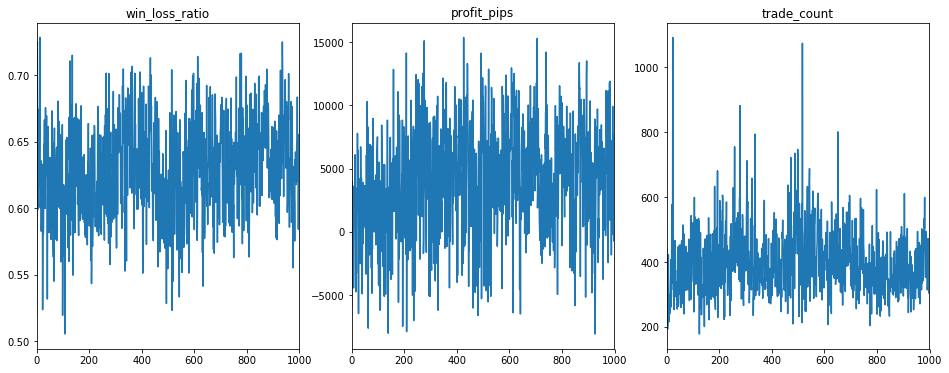

In [14]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [15]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['12h-EUR_USD-high-spread.pkl']

## Test

In [33]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [34]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.0007
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [35]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [36]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
test_results['account_drawdown_max_pips'] = test_results['account_drawdown_max'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))
print('Median drawdown: {0} pips'.format(test_results['account_drawdown_max_pips'].median()))

Median profit: 2071.74999999987 pips
Median drawdown: -783.1000000000032 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133d41c10>]],
      dtype=object)

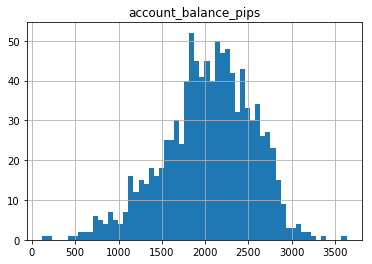

In [37]:
# Historgram of account balance
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133f26790>]],
      dtype=object)

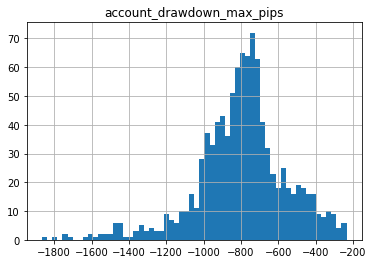

In [38]:
# Historgram of max drawdown
plt.figure(figsize=(16,6))
test_results.hist(column='account_drawdown_max_pips', bins=60)

## Analyse positions on test data

In [39]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [40]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [41]:
env._stats()

{'trade_count': 180,
 'win_loss_ratio': 0.6277777777777778,
 'account_balance': 0.26711999999999336,
 'unrealised_pl': -0.009945000000000093,
 'account_drawdown': -0.025214999999999987,
 'account_drawdown_max': -0.04614999999999969}

In [42]:
position_data = env.price_data.copy()

In [43]:
position_data['position'] = position_data['position'] - 1

In [44]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

182 positions to plot...


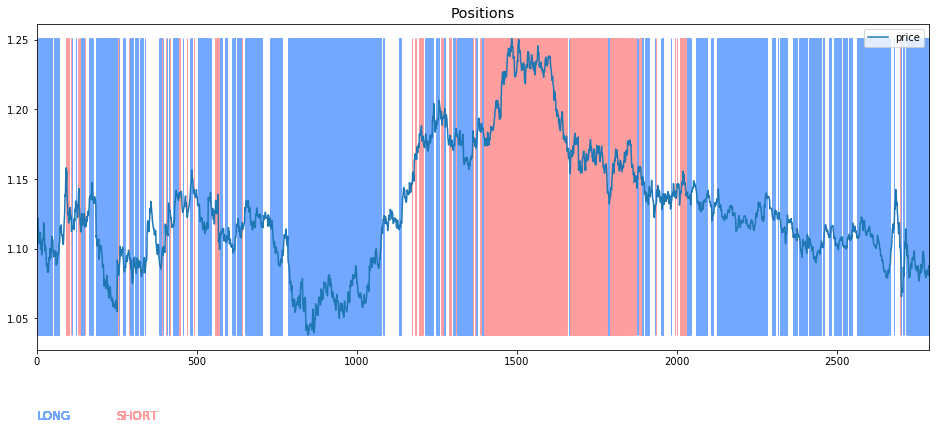

In [45]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [46]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 63.19%
Ratio of long to short positions: 2.18
Median profit: 0.0
Total profit: 0.2707500000000018
Median position length: 2.0
Number of trades: 182


In [47]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2015-06-26 00:00:00,1.11988,2015-06-26 12:00:00,1.11732,1,NaN,NaN,False,NaN
1,2015-06-29 00:00:00,1.11086,2015-06-29 12:00:00,1.12186,1,1.0,0.01100,True,0.01100
2,2015-06-29 12:00:00,1.12186,2015-06-30 12:00:00,1.11341,2,-1.0,0.00845,True,0.01945
3,2015-06-30 12:00:00,1.11341,2015-07-01 00:00:00,1.11037,1,1.0,-0.00304,False,0.01641
4,2015-07-01 12:00:00,1.10370,2015-07-03 12:00:00,1.11137,4,1.0,0.00767,True,0.02408
...,...,...,...,...,...,...,...,...,...
177,2020-03-30 00:00:00,1.10606,2020-03-30 12:00:00,1.10292,1,1.0,-0.00314,False,0.27855
178,2020-03-31 00:00:00,1.09521,2020-04-01 00:00:00,1.09410,2,1.0,-0.00111,False,0.27744
179,2020-04-01 12:00:00,1.09516,2020-04-15 00:00:00,1.09140,21,1.0,-0.00376,False,0.27368
180,2020-04-15 12:00:00,1.09038,2020-05-01 00:00:00,1.09732,25,1.0,0.00694,True,0.28062


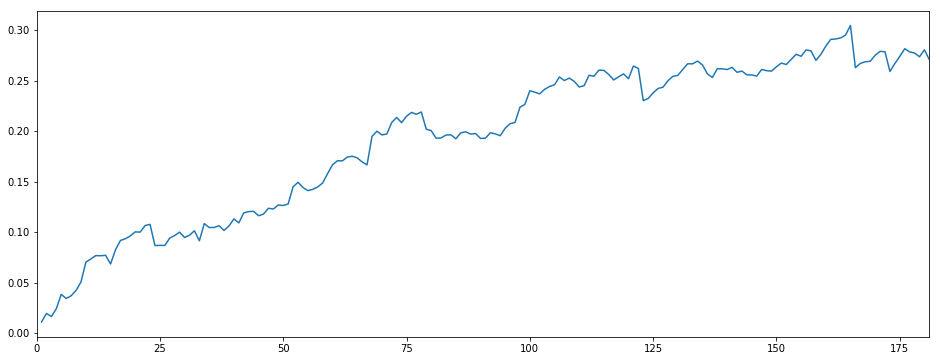

In [48]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.05664999999999998


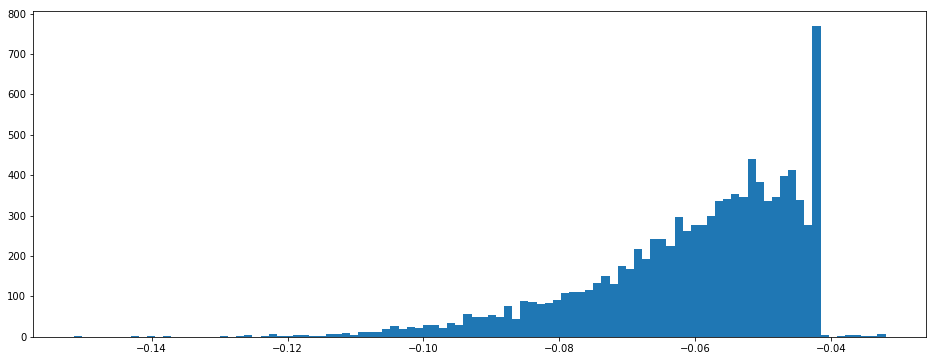

In [49]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);